In [1]:
import os
from pytorch_lightning import loggers as pl_loggers
import pytorch_lightning as pl
from image_inpainting.datamodule.image_net_data_module import ImageNetDataModule
from pytorch_lightning.callbacks import ModelCheckpoint
from image_inpainting.model.context_encoder import ContextEncoder
from image_inpainting.utils import print_results_images

In [2]:
from datetime import datetime
now = datetime.now()
now = now.strftime("%Y-%m-%d_%H-%M-%S")

## Create datamodule

In [3]:
data_dir = "data"

dm = ImageNetDataModule(
    data_dir=os.path.join(data_dir, "imagenet-128"), 
    batch_size_train=512,
    batch_size_val=512,
    batch_size_test=512,
    num_workers=10, 
    pin_memory=True, 
    persistent_workers=True
)

## Create a ContextEncoder model from scratch

In [4]:
model = ContextEncoder(input_size=(3, 128, 128), hidden_size=4000, save_image_per_epoch=True)

## Or load it from a checkpoint

In [5]:
model = ContextEncoder.load_from_checkpoint("checkpoints/imagenet_128_batch_512/2024-12-15_11-52-50-epoch=25-val_loss=5.48.ckpt") # change the path to your checkpoint
model.enable_save_image_per_epoch()
model.to("cuda")

ContextEncoder(
  (psnr_metric): PeakSignalNoiseRatio()
  (joint_loss): JointLoss(
    (rec_loss): ReconstructionLoss()
    (adv_loss): AdversarialLoss(
      (loss_function): BCELoss()
    )
  )
  (rec_loss): ReconstructionLoss()
  (adv_loss): AdversarialLoss(
    (loss_function): BCELoss()
  )
  (generator): AdversarialGenerator(
    (encoder): Encoder(
      (encoder): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): LeakyReLU(negative_slope=0.2, inplace=True)
        (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): LeakyReLU(negative_slope=0.2, inplace=True)
        (8): Conv2

## Train it

In [6]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints/imagenet_128_batch_512',
    filename=now+'-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_top_k=-1,  # Save all checkpoints
    every_n_epochs=1  # Save checkpoint every n epochs
)

tb_logger = pl_loggers.TensorBoardLogger("Context_Encoder_Inpainting")
trainer = pl.Trainer(max_epochs=300, devices=-1, accelerator="cuda", logger=tb_logger, callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(model, dm)

# To continue training:
# trainer.fit(model, dm, ckpt_path="checkpoints/imagenet_128_batch_512/2024-12-15_11-52-50-epoch=25-val_loss=5.48.ckpt")

You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Note: The ImageNet dataset can't be downloaded automatically. Please refer to the README if you haven't already downloaded it. Otherwise you can skip this message.


d:\Programs\Anaconda\envs\image_inpainting\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\CYTechNVME\AIIP_Projet\Image-Inpainting-with-Basic-Convolutional-Networks\checkpoints\imagenet_128_batch_512 exists and is not empty.
Restoring states from the checkpoint path at checkpoints/imagenet_128_batch_512/2024-12-15_11-52-50-epoch=25-val_loss=5.48.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                     | Params | Mode 
-------------------------------------------------------------------
0 | psnr_metric   | PeakSignalNoiseRatio     | 0      | train
1 | joint_loss    | JointLoss                | 0      | train
2 | rec_loss      | ReconstructionLoss       | 0      | train
3 | adv_loss      | AdversarialLoss          | 0      | train
4 | generator     | AdversarialGenerator     | 71.1 M | train
5 | discriminator | AdversarialDiscriminator | 2.8 M  | train
-------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

A notebook "tensorboard" exists if you want to check how the metrics evolve during training

## Results on the last epoch

Here the results of this cell are after 26 epochs on the full Image Net dataset cropped and resized to 128x128.
Note that we changed batch size in the last few epochs from 64 to 512.

- **Number of steps**: 382 755
- **Time**: 11h
- **Observations (with tensorboard)**: On a long run we can see that results are quite interesting, but it's still is blurry. So either the losses coefficients are not adapted (0.999 0.001) to out dataset, our there is a need for more epochs.

In [9]:
trainer.test(model, dm)

Note: The ImageNet dataset can't be downloaded automatically. Please refer to the README if you haven't already downloaded it. Otherwise you can skip this message.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 196/196 [00:34<00:00,  5.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Final PSNR           15.057696342468262
        test_loss            5.390924453735352
        test_psnr           15.057435989379883
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_psnr': 15.057435989379883,
  'test_loss': 5.390924453735352,
  'Final PSNR': 15.057696342468262}]

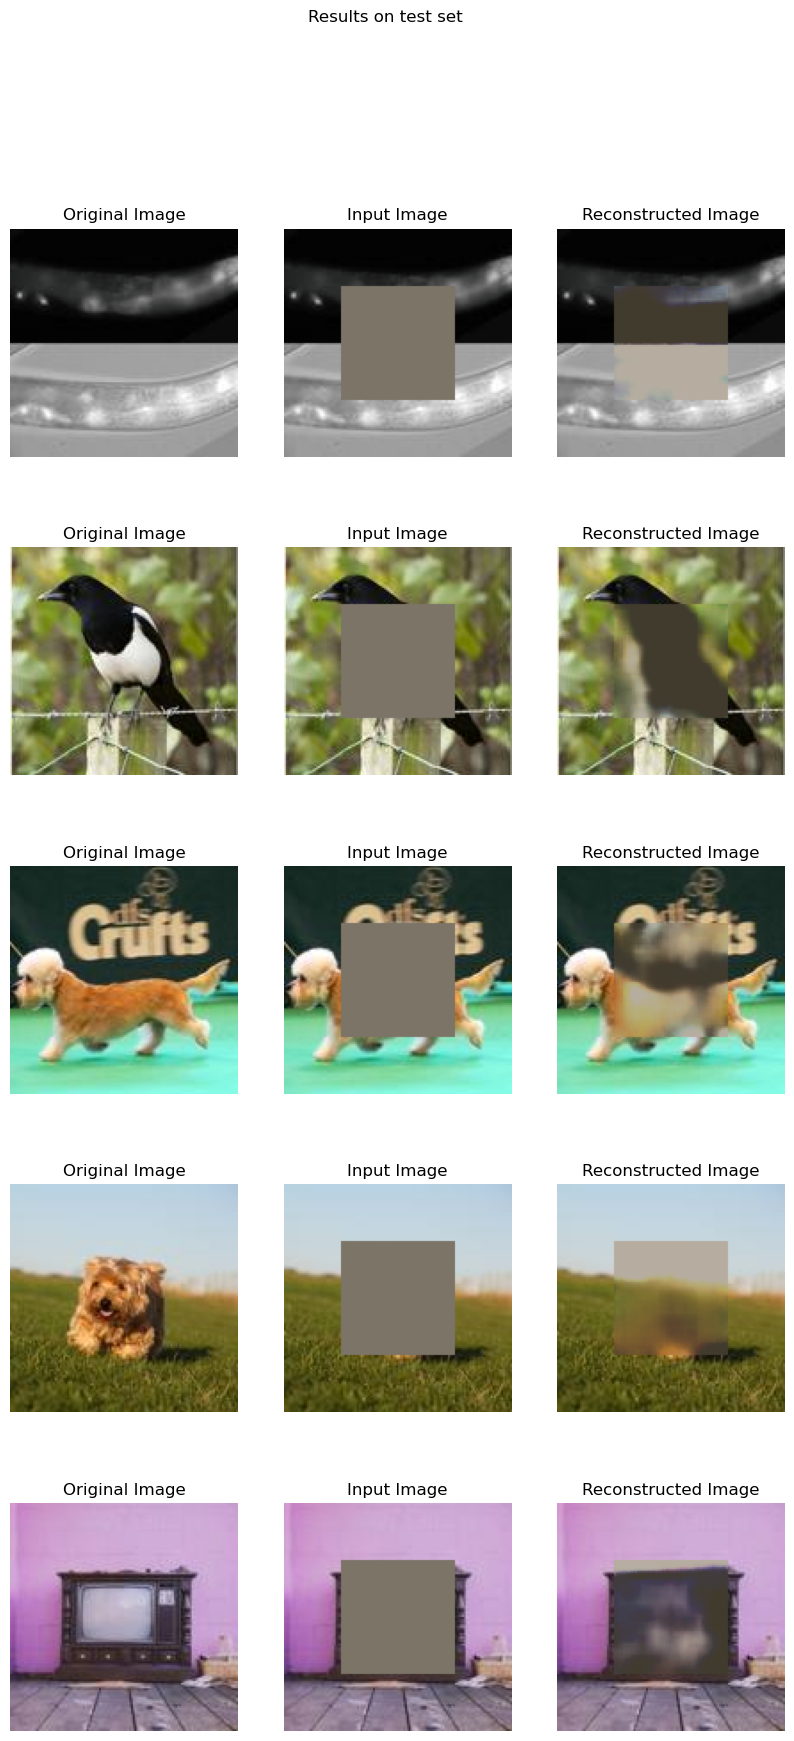

In [10]:
dm.setup("test") # in case "test" wasn't called before this cell

x, y = next(iter(dm.test_dataloader()))
x = x.to(model.device)
y = y.to(model.device)

out = model.forward(x)

print_results_images(x, y, out, "Results on test set", dm.inverse_transform)

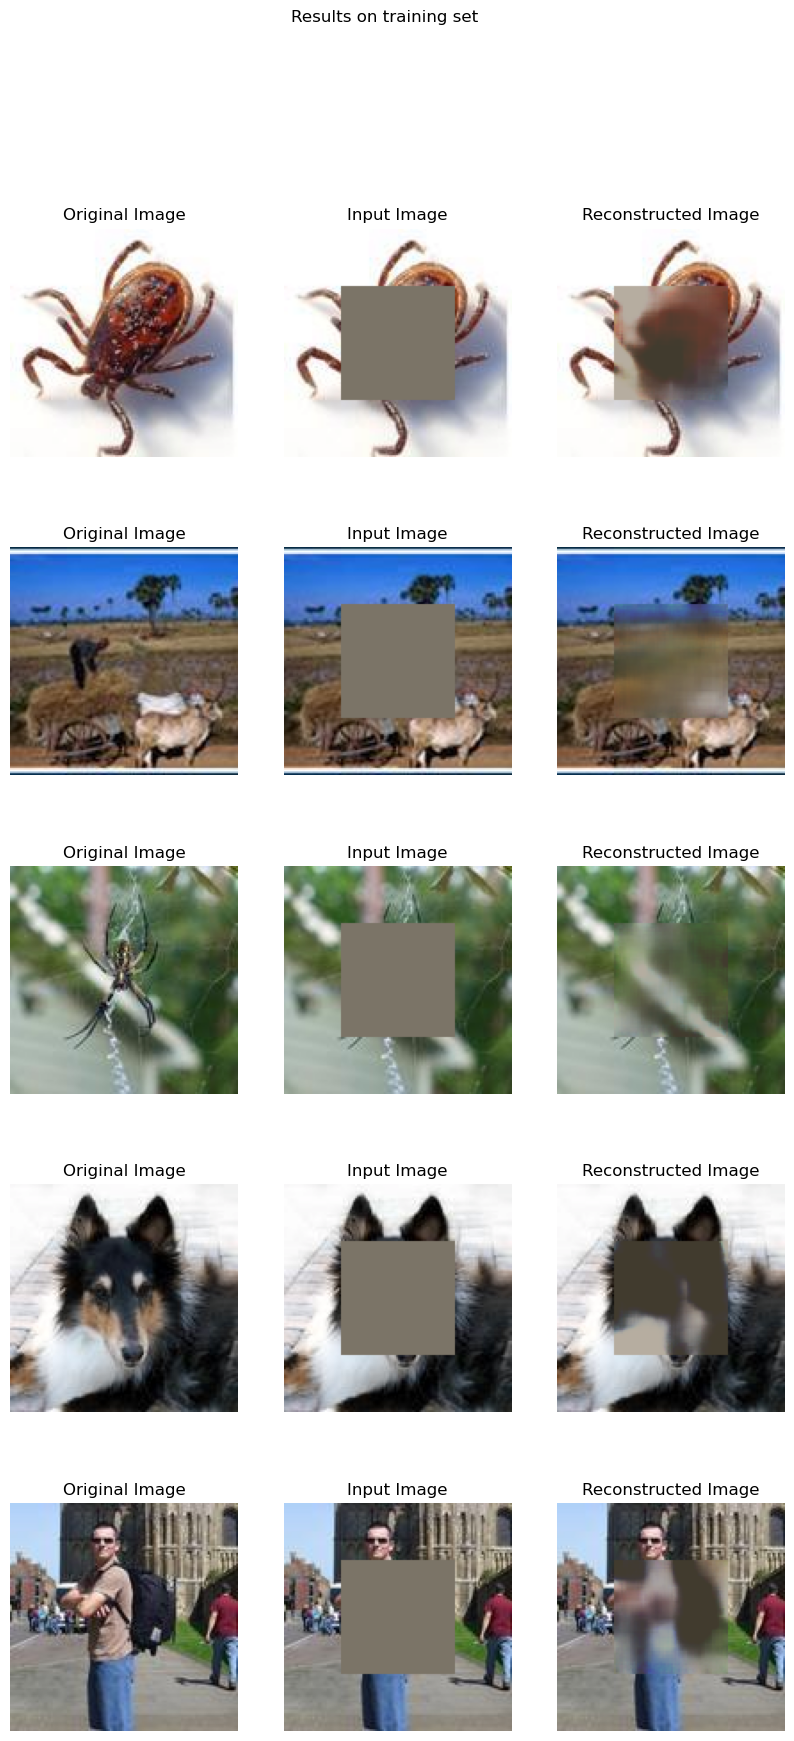

In [11]:
dm.setup("fit") # in case "fit" wasn't called before this cell

x, y = next(iter(dm.train_dataloader()))
x = x.to(model.device)
y = y.to(model.device)
out = model.forward(x)

print_results_images(x, y, out, "Results on training set", dm.inverse_transform)